<a href="https://colab.research.google.com/github/leo-alves-melo/busPredictor/blob/master/dumpBusPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating a dump algorithm for bus prediction given the location of the vehicle

In [1]:
# Install dependencies
!pip install arrow

In [0]:
# Importing packages

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import pprint
import json
import pandas as pd
import numpy as np
import arrow
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from functools import reduce
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# Setting variables

base_api = 'https://api.demo.konkerlabs.net'
username = "student_smartcampus@konkerlabs.com"
password = 'SdExnFiHcGrK'

circulino = "3b7c728c-cf13-45ca-a803-d94a598113d0"
circulino1 = "0b525e25-6962-4ee4-8f8a-834e3e33698d"
circulino2 = "8ab6ae21-9d9e-4637-8c56-60ba15691fd2"
circulino3 = "8f4ab4d2-203e-4043-b4b1-bffca39f8686"
circulino4 = "6ce968a1-a32b-4f8c-bc39-4463f50f4591"
circulino5 = "a028f083-8375-45ec-a42f-7e864fd5f8d7"
circulino6 = "eb0ec27f-16d0-4504-a331-af5b1e24eac6"
circulino7 = "826f5fe4-ec9b-4de7-87f8-93be40963612"
circulino8 = "8a33a2fe-8325-4c71-b937-8cc75b85bca4"

# These are the available circulars because the others do not have data
available_circulars = [circulino4, circulino5, circulino6, circulino7, circulino8]

# Coordinates of the home of the circular
latitude_home = -22.829636
longitude_home = -47.061038
home = {'geolocation':{'lat': latitude_home, 'lon': longitude_home}}

time_formatter1 = '%Y-%m-%dT%H:%M:%S.%fZ'
time_formatter2 = '%Y-%m-%dT%H:%M:%SZ'

In [0]:
# Defining Functions

def get_data(guid):
    global oauth
    
    dt_start = arrow.utcnow().to('America/Sao_Paulo').floor('day')
    timestamp_init = dt_start.shift(days=-7).isoformat()
    channel = 'info'
    timestamp_final = arrow.utcnow().isoformat()
    application = 'default'
    result = []
    lastlen = 0
    while timestamp_init < timestamp_final:
        try:
            stats = oauth.get("https://api.demo.konkerlabs.net/v1/{}/incomingEvents?q=device:{} channel:{} timestamp:>{}&sort=oldest&limit=10000".format(application,guid, channel, timestamp_init)).json()['result']
            if (len(stats)<2) and (lastlen<20000):
                break
            timestamp_init = stats[-1]['timestamp']
            result.extend(stats)
            lastlen = len(stats)
        except:
            pass
    return result

# Calculates the distance in km
def distance_between(position1, position2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(position1['geolocation']['lat'])
    lon1 = radians(position1['geolocation']['lon'])
    lat2 = radians(position2['geolocation']['lat'])
    lon2 = radians(position2['geolocation']['lon'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    return distance

# Calculates the velocity in km/h
def velocity_between(position1, position2):
    
    distance = distance_between(position1, position2)
    
    try:
        time1 = datetime.strptime(position1['timestamp'], time_formatter1)
    except:
        time1 = datetime.strptime(position1['timestamp'], time_formatter2)
        
    try:
        time2 = datetime.strptime(position2['timestamp'], time_formatter1)
    except:
        time2 = datetime.strptime(position2['timestamp'], time_formatter2)
    time_delta = (time2 - time1).total_seconds()/3600

    return distance/time_delta

# Append the next coordenate if it is valid. Returns false when the path ended
def validate_and_append_next_coordinate(coordinate, path): 
    
    # Checks if it is the first coordinate of the path
    if len(path) == 0:
        
        # Check if is close to the home, and if is, append the coordinate
        if distance_between(coordinate, home) < 0.2:
            return True, [coordinate]
        else:
            return True, []
    
    # Check if is duplicated
    if coordinate == path[-1]:
        return True, path
    
    # Checks if the velocity of the next coordinate is too big or greater than zero
    if velocity_between(coordinate, path[-1]) > 100 and velocity_between(coordinate, path[-1]) > 0:
        return True, path
    
    # Checks the time difference
    try:
        time1 = datetime.strptime(path[-1]['timestamp'], time_formatter1)
    except:
        time1 = datetime.strptime(path[-1]['timestamp'], time_formatter2)
        
    try:
        time2 = datetime.strptime(coordinate['timestamp'], time_formatter1)
    except:
        time2 = datetime.strptime(coordinate['timestamp'], time_formatter2)
        
    if (time2 - time1).total_seconds() > 5*60:
        return False, path
    
    # Checks the id
    if coordinate['payload']['id_linha'] != path[-1]['payload']['id_linha']:
        return False, path
    
    
    # Check if the path have at least one coordinate far away from the home, so that the path started
    biggest_distance = 0
    for path_coordinate in path:
        if distance_between(path_coordinate, home) > biggest_distance:
            biggest_distance = distance_between(path_coordinate, home)
    
    
    
    # If the path already started
    if biggest_distance > 1:
        # If we are close to home
        if distance_between(coordinate, home) < 0.2:
            return False, path + [coordinate]
        else:
            return True, path + [coordinate]
    else:
        return True, path + [coordinate]
    
def create_paths(data):
    paths = [[]]
    index = 0
    count = 0
    count_int = 0
    total = len(data)
    for coordinate in data:
        count += 1
        if 100*count/total > count_int + 1:
            count_int += 1

            print(str(count_int) + "%")
        still_appending, paths[index] = validate_and_append_next_coordinate(coordinate, paths[index])
        if not still_appending:
            index += 1
            paths.append([])
    
    return paths

def plot_path(path):
    latitudes = [-coordinate['geolocation']['lat'] for coordinate in path]
    longitudes = [coordinate['geolocation']['lon'] for coordinate in path]
    plt.plot(latitudes, longitudes)
    plt.show()

In [0]:
# Authenticating

client = BackendApplicationClient(client_id=username)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(token_url='{}/v1/oauth/token'.format(base_api),client_id=username,client_secret=password)

In [0]:
# Reading all circular data

data = []

for circular in available_circulars:
    data += get_data(circular)

In [7]:
# Getting all possible id_linha

id_lines = {}
for json in data:
    id_line = json['payload']['id_linha']
    if id_line in id_lines:
        id_lines[id_line] += 1
    else:
        id_lines[id_line] = 1

print(id_lines)

{2: 50478, 3: 21005, 1: 99865, 4: 94540}


In [8]:
paths = create_paths(data)

1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


    100% |████████████████████████████████| 122kB 6.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/81/6a/76/4dd6a7cc310ba765894159ee84871e8cd55221d82ef14b81a1
Successfully built gmplot


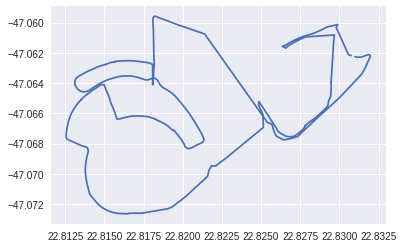

In [11]:
plot_path(paths[0])